In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
!ln -s /content/gdrive/My\ Drive/ /mydrive
%cd /mydrive/yolov9-main

Mounted at /content/gdrive
/content/gdrive/My Drive/yolov9-main


In [ ]:
import os
import json

def count_images(image_dir, exts={".jpg", ".jpeg", ".png", ".bmp", ".webp"}):
    image_count = 0
    for filename in os.listdir(image_dir):
        if os.path.splitext(filename.lower())[1] in exts:
            image_count += 1
    print(f"Total images: {image_count}")

count_images("datasets/PhenoBench/train/images")
count_images("datasets/PhenoBench/val/images")

Total images: 1407
Total images: 772


In [ ]:
import os
import numpy as np
from PIL import Image

def check_semantic_ids(semantic_dir):
    all_ids = set()
    for filename in os.listdir(semantic_dir):
        if filename.endswith(".png"):
            mask = np.array(Image.open(os.path.join(semantic_dir, filename)))
            unique_ids = np.unique(mask)
            all_ids.update(unique_ids.tolist())
    return sorted(all_ids)

semantic_dir = "datasets/PhenoBench/train/semantics"  # or train folder
unique_ids = check_semantic_ids(semantic_dir)
print("Unique semantic IDs found:", unique_ids)

Unique semantic IDs found: [0, 1, 2, 3, 4]


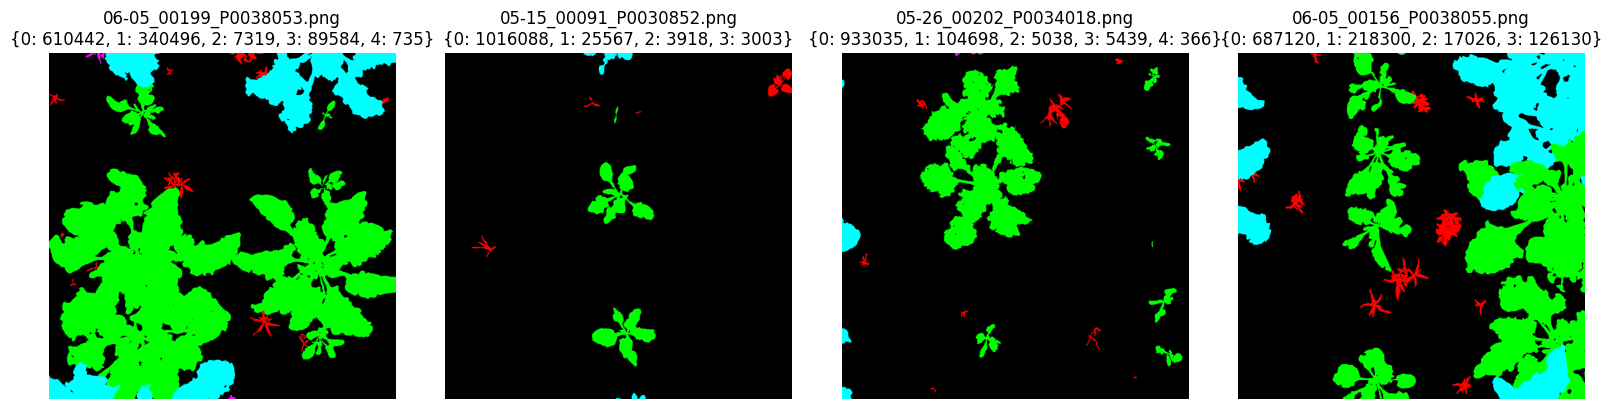

In [ ]:
import os
import random
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# Define class ID to RGB color mapping
CATEGORY_COLORS = {
    0: [0, 0, 0],         # background
    1: [0, 255, 0],       # crop (green)
    2: [255, 0, 0],       # weed (red)
    3: [0, 255, 255],     # partial-crop (cyan)
    4: [255, 0, 255],     # partial-weed (purple)
}

def decode_mask(mask):
    """Convert class ID mask to RGB color mask"""
    h, w = mask.shape
    color_mask = np.zeros((h, w, 3), dtype=np.uint8)
    for class_id, color in CATEGORY_COLORS.items():
        color_mask[mask == class_id] = color
    return color_mask

def count_classes(mask):
    """Count pixel occurrences for each class"""
    unique, counts = np.unique(mask, return_counts=True)
    return dict(zip(unique.tolist(), counts.tolist()))

def visualize_random_semantics(mask_dir, num_samples=4):
    mask_files = [f for f in os.listdir(mask_dir) if f.endswith('.png')]
    selected = random.sample(mask_files, num_samples)

    fig, axes = plt.subplots(1, num_samples, figsize=(16, 4))
    for i, filename in enumerate(selected):
        path = os.path.join(mask_dir, filename)
        mask = np.array(Image.open(path))
        color_mask = decode_mask(mask)
        class_counts = count_classes(mask)

        axes[i].imshow(color_mask)
        axes[i].set_title(f"{filename}\n{class_counts}")
        axes[i].axis("off")

    plt.tight_layout()
    plt.show()

# Example usage:
visualize_random_semantics("datasets/PhenoBench/train/semantics")

In [2]:
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

In [ ]:
!pip install segmentation-models-pytorch albumentations
!pip install torchmetrics

In [ ]:
!pip install timm

In [5]:
import os
import json
import numpy as np
import random
import matplotlib.pyplot as plt
import cv2
from PIL import Image
from tqdm import tqdm
import torchmetrics
from torch.utils.data import Dataset
import albumentations as A
from albumentations.pytorch import ToTensorV2
import segmentation_models_pytorch as smp
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from segmentation_models_pytorch.utils import losses, metrics

In [11]:
# Albumentations transforms for train and valid
train_transform = A.Compose([
    A.Resize(512, 512),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.Normalize(mean=(0.485, 0.456, 0.406),  # ImageNet stats
                std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

valid_transform = A.Compose([
    A.Resize(512, 512),
    A.Normalize(mean=(0.485, 0.456, 0.406),
                std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

class PhenoBenchDataset(Dataset):
    def __init__(self, images_dir, masks_dir, transform=None):
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.transform = transform
        self.images = sorted([f for f in os.listdir(images_dir) if f.endswith(('.jpg', '.png', '.jpeg'))])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.images_dir, self.images[idx])
        mask_path = os.path.join(self.masks_dir, self.images[idx].replace('.jpg', '.png').replace('.jpeg', '.png'))

        image = np.array(Image.open(img_path).convert("RGB"))
        mask = np.array(Image.open(mask_path))

        # Apply albumentations transforms
        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']

        # SMP expects masks as LongTensor for loss
        return image, mask.long()

# Example usage
train_dataset = PhenoBenchDataset(
    images_dir="datasets/PhenoBench/train/images",
    masks_dir="datasets/PhenoBench/train/semantics",
    transform=train_transform
)

valid_dataset = PhenoBenchDataset(
    images_dir="datasets/PhenoBench/val/images",
    masks_dir="datasets/PhenoBench/val/semantics",
    transform=valid_transform
)

In [7]:
# Number of classes (including background)
NUM_CLASSES = 5

# Setup device (use GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Instantiate model and move to device
model = smp.PAN(
    encoder_name="resnet101",
    encoder_weights="imagenet",
    in_channels=3,
    classes=NUM_CLASSES,
)

model = model.to(device)

Using device: cuda


In [12]:
from torch.utils.data import DataLoader

BATCH_SIZE = 8
NUM_WORKERS = 4

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=True
)

valid_loader = DataLoader(
    valid_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True
)

In [ ]:
# Define loss functions
dice_loss = smp.losses.DiceLoss(mode='multiclass')
ce_loss = smp.losses.SoftCrossEntropyLoss(smooth_factor=0.05)

def combined_loss(pred, target):
    return dice_loss(pred, target) + ce_loss(pred, target)

In [ ]:
# Setup optimizer & scheduler
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20)

# Metric tracker (IoU)
train_iou_metric = torchmetrics.JaccardIndex(task='multiclass', num_classes=NUM_CLASSES).to(device)
val_iou_metric = torchmetrics.JaccardIndex(task='multiclass', num_classes=NUM_CLASSES).to(device)

def train_one_epoch(model, loader):
    model.train()
    running_loss = 0.0
    train_iou_metric.reset()

    for images, masks in tqdm(loader, desc="Train", leave=False):
        images, masks = images.to(device), masks.to(device)

        optimizer.zero_grad()
        outputs = model(images)

        loss = combined_loss(outputs, masks)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        train_iou_metric.update(outputs.softmax(dim=1), masks)

    epoch_loss = running_loss / len(loader)
    epoch_iou = train_iou_metric.compute().item()
    return epoch_loss, epoch_iou

def validate_one_epoch(model, loader):
    model.eval()
    running_loss = 0.0
    val_iou_metric.reset()

    with torch.no_grad():
        for images, masks in tqdm(loader, desc="Val", leave=False):
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)

            loss = combined_loss(outputs, masks)
            running_loss += loss.item()

            val_iou_metric.update(outputs.softmax(dim=1), masks)

    epoch_loss = running_loss / len(loader)
    epoch_iou = val_iou_metric.compute().item()
    return epoch_loss, epoch_iou

In [ ]:
NUM_EPOCHS = 40
best_iou = 0.0
save_path = "output/best_pan_model.pth"

for epoch in range(1, NUM_EPOCHS + 1):
    print(f"\n🌱 Epoch {epoch}/{NUM_EPOCHS}")

    train_loss, train_iou = train_one_epoch(model, train_loader)
    val_loss, val_iou = validate_one_epoch(model, valid_loader)

    scheduler.step()

    print(f"Train Loss: {train_loss:.4f} | IoU: {train_iou:.4f}")
    print(f"Val   Loss: {val_loss:.4f} | IoU: {val_iou:.4f}")

    # Save best model
    if val_iou > best_iou:
        best_iou = val_iou
        torch.save(model.state_dict(), save_path)
        print(f"✅ Best model saved with IoU = {val_iou:.4f}")


🌱 Epoch 1/40


Train Loss: 1.1527 | IoU: 0.3764
Val   Loss: 0.8375 | IoU: 0.5177
✅ Best model saved with IoU = 0.5177

🌱 Epoch 2/40


Train Loss: 0.7817 | IoU: 0.5331
Val   Loss: 0.7835 | IoU: 0.5361
✅ Best model saved with IoU = 0.5361

🌱 Epoch 3/40


Train Loss: 0.7308 | IoU: 0.5750
Val   Loss: 0.7390 | IoU: 0.5871
✅ Best model saved with IoU = 0.5871

🌱 Epoch 4/40


Train Loss: 0.6993 | IoU: 0.6000
Val   Loss: 0.7369 | IoU: 0.5742

🌱 Epoch 5/40


Train Loss: 0.6865 | IoU: 0.6108
Val   Loss: 0.7230 | IoU: 0.5876
✅ Best model saved with IoU = 0.5876

🌱 Epoch 6/40


Train Loss: 0.6716 | IoU: 0.6304
Val   Loss: 0.7216 | IoU: 0.6053
✅ Best model saved with IoU = 0.6053

🌱 Epoch 7/40


Train Loss: 0.6536 | IoU: 0.6561
Val   Loss: 0.7154 | IoU: 0.6163
✅ Best model saved with IoU = 0.6163

🌱 Epoch 8/40


Train Loss: 0.6473 | IoU: 0.6727
Val   Loss: 0.6979 | IoU: 0.6459
✅ Best model saved with IoU = 0.6459

🌱 Epoch 9/40


Train Loss: 0.6451 | IoU: 0.6829
Val   Loss: 0.6913 | IoU: 0.6474
✅ Best model saved with IoU = 0.6474

🌱 Epoch 10/40


Train Loss: 0.6391 | IoU: 0.6949
Val   Loss: 0.6889 | IoU: 0.6567
✅ Best model saved with IoU = 0.6567

🌱 Epoch 11/40


Train Loss: 0.6194 | IoU: 0.7103
Val   Loss: 0.6782 | IoU: 0.6602
✅ Best model saved with IoU = 0.6602

🌱 Epoch 12/40


Train Loss: 0.6247 | IoU: 0.7202
Val   Loss: 0.6847 | IoU: 0.6466

🌱 Epoch 13/40


Train Loss: 0.6145 | IoU: 0.7270
Val   Loss: 0.6783 | IoU: 0.6606
✅ Best model saved with IoU = 0.6606

🌱 Epoch 14/40


Train Loss: 0.6071 | IoU: 0.7424
Val   Loss: 0.6763 | IoU: 0.6693
✅ Best model saved with IoU = 0.6693

🌱 Epoch 15/40


Train Loss: 0.6013 | IoU: 0.7506
Val   Loss: 0.6757 | IoU: 0.6726
✅ Best model saved with IoU = 0.6726

🌱 Epoch 16/40


Train Loss: 0.5986 | IoU: 0.7594
Val   Loss: 0.6858 | IoU: 0.6707

🌱 Epoch 17/40


Train Loss: 0.5958 | IoU: 0.7621
Val   Loss: 0.6806 | IoU: 0.6724

🌱 Epoch 18/40


Train Loss: 0.5877 | IoU: 0.7697
Val   Loss: 0.6839 | IoU: 0.6722

🌱 Epoch 19/40


Train Loss: 0.5885 | IoU: 0.7737
Val   Loss: 0.6816 | IoU: 0.6735
✅ Best model saved with IoU = 0.6735

🌱 Epoch 20/40


Train Loss: 0.5809 | IoU: 0.7706
Val   Loss: 0.6819 | IoU: 0.6737
✅ Best model saved with IoU = 0.6737

🌱 Epoch 21/40


Train Loss: 0.5896 | IoU: 0.7755
Val   Loss: 0.6831 | IoU: 0.6746
✅ Best model saved with IoU = 0.6746

🌱 Epoch 22/40


Train Loss: 0.5892 | IoU: 0.7736
Val   Loss: 0.6850 | IoU: 0.6743

🌱 Epoch 23/40


Train Loss: 0.5872 | IoU: 0.7734
Val   Loss: 0.6822 | IoU: 0.6740

🌱 Epoch 24/40


Train Loss: 0.5830 | IoU: 0.7755
Val   Loss: 0.6829 | IoU: 0.6736

🌱 Epoch 25/40


Train Loss: 0.5795 | IoU: 0.7750
Val   Loss: 0.6887 | IoU: 0.6733

🌱 Epoch 26/40


Train Loss: 0.5825 | IoU: 0.7773
Val   Loss: 0.6869 | IoU: 0.6730

🌱 Epoch 27/40


Train Loss: 0.5870 | IoU: 0.7665
Val   Loss: 0.6986 | IoU: 0.6533

🌱 Epoch 28/40


Train Loss: 0.5937 | IoU: 0.7599
Val   Loss: 0.6993 | IoU: 0.6490

🌱 Epoch 29/40


Train Loss: 0.5916 | IoU: 0.7641
Val   Loss: 0.7039 | IoU: 0.6385

🌱 Epoch 30/40


Train Loss: 0.6105 | IoU: 0.7247
Val   Loss: 0.7019 | IoU: 0.6574

🌱 Epoch 31/40


Train Loss: 0.5946 | IoU: 0.7487
Val   Loss: 0.6920 | IoU: 0.6617

🌱 Epoch 32/40


Train Loss: 0.6035 | IoU: 0.7489
Val   Loss: 0.6985 | IoU: 0.6588

🌱 Epoch 33/40


Train Loss: 0.6024 | IoU: 0.7530
Val   Loss: 0.7070 | IoU: 0.6466

🌱 Epoch 34/40


Train Loss: 0.6054 | IoU: 0.7394
Val   Loss: 0.7180 | IoU: 0.6398

🌱 Epoch 35/40


Train Loss: 0.5982 | IoU: 0.7492
Val   Loss: 0.7046 | IoU: 0.6547

🌱 Epoch 36/40


Train Loss: 0.6037 | IoU: 0.7382
Val   Loss: 0.6961 | IoU: 0.6641

🌱 Epoch 37/40


Train Loss: 0.6116 | IoU: 0.7232
Val   Loss: 0.7107 | IoU: 0.6355

🌱 Epoch 38/40


Train Loss: 0.5956 | IoU: 0.7504
Val   Loss: 0.7050 | IoU: 0.6502

🌱 Epoch 39/40


Train Loss: 0.5849 | IoU: 0.7664
Val   Loss: 0.7137 | IoU: 0.6401

🌱 Epoch 40/40


Train Loss: 0.5909 | IoU: 0.7613
Val   Loss: 0.7053 | IoU: 0.6361


In [8]:
model = smp.PAN(
    encoder_name="resnet101",
    encoder_weights=None,
    in_channels=3,
    classes=5,
)
model.load_state_dict(torch.load("output/best_pan_model.pth", map_location=device))
model = model.to(device)
model.eval()
print("✅ Best model loaded.")

✅ Best model loaded.


In [ ]:
from torchmetrics.classification import MulticlassJaccardIndex, MulticlassPrecision, MulticlassRecall, MulticlassF1Score

# Initialize metrics
iou_metric = MulticlassJaccardIndex(num_classes=NUM_CLASSES, average=None).to(device)
precision_metric = MulticlassPrecision(num_classes=NUM_CLASSES, average=None).to(device)
recall_metric = MulticlassRecall(num_classes=NUM_CLASSES, average=None).to(device)
f1_metric = MulticlassF1Score(num_classes=NUM_CLASSES, average=None).to(device)

# Reset metrics
iou_metric.reset()
precision_metric.reset()
recall_metric.reset()
f1_metric.reset()

# Accumulate across validation set
model.eval()
with torch.no_grad():
    for images, masks in tqdm(valid_loader, desc="Evaluating"):
        images, masks = images.to(device), masks.to(device)
        outputs = model(images)
        preds = torch.softmax(outputs, dim=1).argmax(dim=1)

        iou_metric.update(preds, masks)
        precision_metric.update(preds, masks)
        recall_metric.update(preds, masks)
        f1_metric.update(preds, masks)

# Get results
per_class_iou = iou_metric.compute().cpu().numpy()
per_class_precision = precision_metric.compute().cpu().numpy()
per_class_recall = recall_metric.compute().cpu().numpy()
per_class_f1 = f1_metric.compute().cpu().numpy()

Evaluating: 100%|██████████| 97/97 [00:11<00:00,  8.33it/s]


In [ ]:
CLASS_NAMES = ["background", "crop", "weed", "partial-crop", "partial-weed"]

print("📊 Per-Class Evaluation Metrics:")
print(f"{'Class':<15} {'IoU':>6} {'Prec':>6} {'Rec':>6} {'F1':>6}")
print("-" * 40)
for i, class_name in enumerate(CLASS_NAMES):
    print(f"{class_name:<15} "
          f"{per_class_iou[i]:6.3f} "
          f"{per_class_precision[i]:6.3f} "
          f"{per_class_recall[i]:6.3f} "
          f"{per_class_f1[i]:6.3f}")

📊 Per-Class Evaluation Metrics:
Class              IoU   Prec    Rec     F1
----------------------------------------
background       0.988  0.995  0.993  0.994
crop             0.877  0.923  0.946  0.934
weed             0.561  0.710  0.727  0.719
partial-crop     0.738  0.881  0.820  0.850
partial-weed     0.209  0.350  0.342  0.346


In [27]:
import matplotlib.pyplot as plt
import random
import numpy as np
import torchvision.transforms.functional as TF
from PIL import Image
from IPython.display import display, Image as IPyImage
import io

CATEGORY_COLORS = {
    0: [0, 0, 0],
    1: [0, 255, 0],
    2: [255, 0, 0],
    3: [0, 255, 255],
    4: [255, 0, 255],
}

IMG_MEAN = np.array([0.485, 0.456, 0.406])
IMG_STD = np.array([0.229, 0.224, 0.225])

def decode_mask(mask):
    h, w = mask.shape
    rgb = np.zeros((h, w, 3), dtype=np.uint8)
    for cls, color in CATEGORY_COLORS.items():
        rgb[mask == cls] = color
    return rgb

def denormalize(img_tensor):
    img = img_tensor.permute(1, 2, 0).cpu().numpy()
    img = (img * IMG_STD + IMG_MEAN) * 255.0
    return np.clip(img, 0, 255).astype(np.uint8)

def visualize_predictions(model, dataset, num_images=4, alpha=0.4):
    model.eval()
    indices = random.sample(range(len(dataset)), num_images)
    fig, axes = plt.subplots(num_images, 4, figsize=(16, 4 * num_images))

    if num_images == 1:
        axes = np.expand_dims(axes, 0)

    for row, idx in enumerate(indices):
        image, gt = dataset[idx]
        input_tensor = image.unsqueeze(0).to(device)
        with torch.no_grad():
            logits = model(input_tensor)
            pred = torch.argmax(logits, dim=1).squeeze().cpu().numpy()

        image_np = denormalize(image)
        gt_rgb = decode_mask(gt.numpy())
        pred_rgb = decode_mask(pred)
        overlay = ((1 - alpha) * image_np + alpha * pred_rgb).astype(np.uint8)

        axes[row][0].imshow(image_np)
        axes[row][1].imshow(gt_rgb)
        axes[row][2].imshow(pred_rgb)
        axes[row][3].imshow(overlay)

        for col in range(4):
            axes[row][col].axis('off')

    for col, title in enumerate(["Original", "Ground Truth", "Prediction", "Overlay"]):
        axes[0][col].set_title(title, fontsize=14)

    plt.tight_layout()
    buf = io.BytesIO()
    fig.savefig(buf, format='png', dpi=80)
    plt.close(fig)
    buf.seek(0)
    display(IPyImage(data=buf.read()))

In [30]:
# Example: visualize 3 random samples with alpha=0.4
visualize_predictions(model, valid_dataset, num_images=3, alpha=0.4)

In [ ]:
# Constants (reuse your normalization stats and colors)
IMG_MEAN = np.array([0.485, 0.456, 0.406])
IMG_STD = np.array([0.229, 0.224, 0.225])

CATEGORY_COLORS = {
    0: [0, 0, 0],         # background
    1: [0, 255, 0],       # crop
    2: [255, 0, 0],       # weed
    3: [0, 255, 255],     # partial-crop
    4: [255, 0, 255],     # partial-weed
}

def decode_mask(mask):
    h, w = mask.shape
    rgb_mask = np.zeros((h, w, 3), dtype=np.uint8)
    for class_id, color in CATEGORY_COLORS.items():
        rgb_mask[mask == class_id] = color
    return rgb_mask

preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=IMG_MEAN.tolist(), std=IMG_STD.tolist()),
])

def visualize_test_predictions(model, test_img_dir, num_images=6, alpha=0.4):
    model.eval()

    # List all images in test dir
    all_images = [f for f in os.listdir(test_img_dir) if f.lower().endswith((".jpg", ".png", ".jpeg", ".bmp"))]
    indices = random.sample(range(len(all_images)), num_images)

    ncols = 6  # 2 images × 3 cols (ori, pred, overlay)
    nrows = (num_images + 1) // 2

    fig, axes = plt.subplots(nrows, ncols, figsize=(20, 4 * nrows))
    if nrows == 1:
        axes = np.expand_dims(axes, axis=0)

    for i, idx in enumerate(indices):
        filename = all_images[idx]
        path = os.path.join(test_img_dir, filename)

        image = Image.open(path).convert("RGB")
        input_tensor = preprocess(image).unsqueeze(0).to(device)

        with torch.no_grad():
            pred_logits = model(input_tensor)
            pred_mask = torch.argmax(pred_logits, dim=1).squeeze().cpu().numpy()

        image_np = np.array(image)
        pred_rgb = decode_mask(pred_mask)
        overlay = ((1 - alpha) * image_np + alpha * pred_rgb).astype(np.uint8)

        row = i // 2
        col_base = (i % 2) * 3

        axes[row][col_base].imshow(image_np)
        axes[row][col_base].axis("off")
        if row == 0:
            axes[row][col_base].set_title("Original", fontsize=12)

        axes[row][col_base + 1].imshow(pred_rgb)
        axes[row][col_base + 1].axis("off")
        if row == 0:
            axes[row][col_base + 1].set_title("Prediction", fontsize=12)

        axes[row][col_base + 2].imshow(overlay)
        axes[row][col_base + 2].axis("off")
        if row == 0:
            axes[row][col_base + 2].set_title("Overlay", fontsize=12)

    plt.tight_layout()
    plt.show()

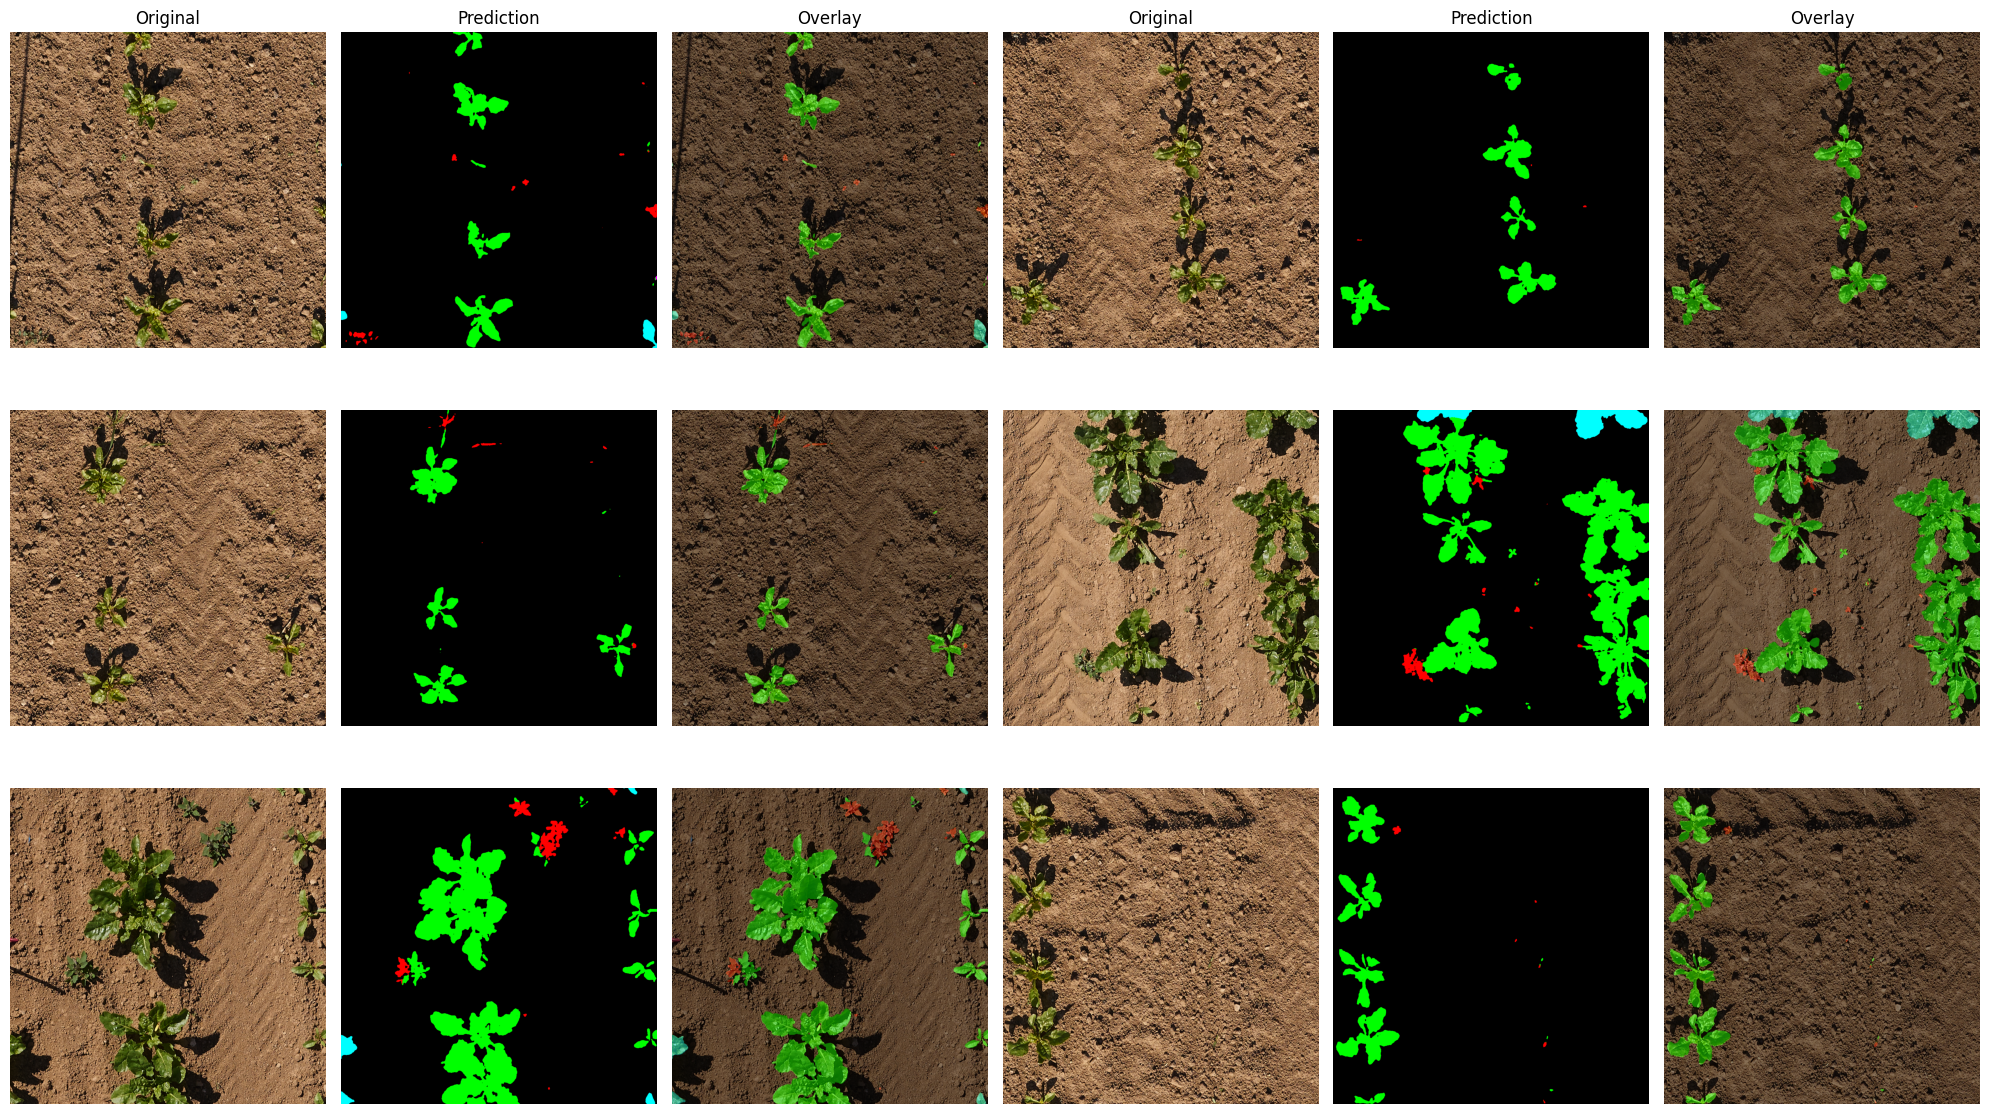

In [ ]:
# Usage example:
visualize_test_predictions(model, "datasets/PhenoBench/test/images", num_images=6, alpha=0.4)